AAS Convex Trajectory Update 

In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn
from importlib import reload
import copy
# seaborn.set_style("whitegrid")
from scipy.io import loadmat, savemat
from scipy.interpolate import interp1d 

print(plt.style.available)
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-whitegrid')

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', '_classic_test']


In [2]:
from EntryGuidance import EntryEquations as EE
from EntryGuidance import MonteCarloV as MC
from EntryGuidance import Parachute, InitialState
from EntryGuidance.Simulation import Simulation, Cycle
from EntryGuidance.Triggers import AccelerationTrigger, VelocityTrigger, RangeToGoTrigger, SRPTrigger
from Utils import gpops 
from Utils.submatrix import submatrix 
from Utils.smooth import smooth 

In [3]:
x0 = InitialState.InitialState(rtg=870e3)
model = EE.Entry()
target = model.planet.coord(x0[1], x0[2], 0, dr=870e3, cr=0e3)
print("Initial State: {}".format(x0))
print("Target: {}".format(target))

Initial State: [ 3.54000000e+06  0.00000000e+00  0.00000000e+00  5.50500000e+03
 -2.46964089e-01  0.00000000e+00  8.70000000e+05  2.80400000e+03]
Target: (0.25610833088018825, 1.551123825447439e-17)


In [92]:
def get_opt_traj(x0, bank, target):
    y0 = [float(x) for x in x0[:6]]
    target = [float(t) for t in target]
    traj = gpops.EG([y0, float(bank), target[0], target[1]])
    return traj

def plot_gpops(x, label='', figsize=(10,6), fontsize=18, linespec={}):
#     x = np.array(traj['state'])
    r,th,ph,v,fpa,heading,bank = x.T
    
    h = r/1000 - 3397
    dr = th*3397
    cr = -ph*3397
    
    opts = {'fontsize' : fontsize}
    
    plt.figure(1, figsize=figsize)
    plt.plot(v[h>8.8], h[h>8.8], label=label, **linespec)
    plt.xlabel('Velocity (m/s)', **opts)
    plt.ylabel('Altitude (km)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.figure(2, figsize=figsize)
    plt.plot(cr, dr, label=label, **linespec)
    plt.ylabel('Downrange (km)', **opts)
    plt.xlabel('Crossrange (km)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.figure(3, figsize=figsize)
    plt.plot(v, np.degrees(fpa), label=label, **linespec)
    plt.xlabel('Velocity', **opts)
    plt.ylabel('FPA (deg)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.figure(4, figsize=figsize)
    plt.plot(v, np.degrees(heading), label=label, **linespec)
    plt.xlabel('Velocity (m/s)', **opts)
    plt.ylabel('Heading (deg)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.figure(5, figsize=figsize)
    plt.plot(v, np.degrees(bank), label=label, **linespec)
    plt.xlabel('Velocity (m/s)', **opts)
    plt.ylabel('Bank Angle (deg)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

In [83]:
traj = get_opt_traj(x0, 0., target)
# plot_gpops(np.array(traj['state']))

In [109]:
class ConvexPC(object):
    """ Defines a controller class based on convex optimization updates to a trajectory

    """
    def __init__(self, traj, tspan=30, verbose=False):
        
        self.history = []
        self.t_replan = []
        self.x_replan = []
        self.bank_replan = []
        self.tspan = tspan
        self.set_profile(traj)
        self.target = self.history[0][-1, 1:3]
        self.verbose=verbose
        
    def controller(self, time, velocity, current_state, bank, **kwargs):
        
        if not self.t_replan:
            self.t_replan.append(time)
            self.x_replan.append(current_state)
            self.bank_replan.append(bank)
            
        if self.trigger(time, velocity):
            self.t_replan.append(time)
            self.x_replan.append(current_state)
            self.bank_replan.append(bank)
            
            if self.verbose: print("Replanning...")
            traj = get_opt_traj(current_state, bank, self.target)
            if self.verbose: print("    ...done")
            self.set_profile(traj)
            
        return self.profile(velocity)
        
        
    def trigger(self, time, velocity):
        return time - self.t_replan[-1] >= self.tspan and velocity > 1000
        
    def set_profile(self, traj):
        x = np.array(traj['state'])
        self.history.append(x)
        
        r,th,ph,v,fpa,heading,bank = x.T
        
        self.profile = interp1d(v, bank, kind='cubic', axis=0, copy=True, bounds_error=False, fill_value=(bank[-1], bank[0]), assume_sorted=False)
        
        
    def plot_history(self, fontsize=16, zoom=False, save=False):
        # each element is a full set of states
        plot_gpops(self.history[0], linespec={'linewidth':3}, label="Nominal", fontsize=fontsize)

        for i,(x,b,traj) in enumerate(zip(self.x_replan[1:], self.bank_replan[1:], self.history[1:])):
            y = np.append(x[0:6], b)
            plot_gpops(y, linespec={'marker':'o', 'markersize':9, 'color':'k'}) #label="Update {}".format(i+1), 
            plot_gpops(traj, label="Update {}".format(i+1), linespec={'linewidth':3}, fontsize=fontsize) # 
        
        Parachute.Draw(figure=1)

        if zoom:
            plt.axis([300, 900, 5.5, 18])
        names = ["AltVel","DRCR","FPA","Heading","Bank"]
        for i in range(1,6):
            plt.figure(i)
            plt.legend(fontsize=14)
#             plt.grid('off')
            if save:
                plt.savefig("./results/convex/{}_history.png".format(names[i-1]), bbox_inches='tight')
        
    def plot_traj(self, sim, save=False, fontsize=16, draw_parachute=False):
        plot_gpops(self.history[0], label="Nominal",fontsize=fontsize,linespec={'linewidth':3})
        traj_ = np.concatenate((sim.history[:,0:6], sim.control_history[:,0:1]), axis=1)
        plot_gpops(traj_, label="Flown", fontsize=fontsize, linespec={'linewidth':3})
        
        for i,(x,b) in enumerate(zip(self.x_replan, self.bank_replan)):
            y = np.append(x[0:6], b)
            plot_gpops(y, linespec={'marker':'o', 'color':'black','markersize':9}) #label="Update {}".format(i+1),
        
        
        
        if draw_parachute:
            Parachute.Draw(figure=1)
#             plt.axis([300, 500, 5.5, 18])
        names = ["AltVel","DRCR","FPA","Heading","Bank"]
        for i in range(1,6):
            plt.figure(i)
            plt.legend(fontsize=14)
#             plt.grid('off')
            if save:
                plt.savefig("./results/convex/{}.png".format(names[i-1]), bbox_inches='tight')

            
        

In [110]:
conditions = [AccelerationTrigger('drag', 2), SRPTrigger(0, 480, 200)]
states = ["Drag < 2 m/s^2", "Guided Entry"]
sim = Simulation(cycle=Cycle(1), output=True, **{ 'states' : states,
              'conditions' : conditions })


OL = ConvexPC(traj, 1e6) # never replans, just open loop essentially
CL = ConvexPC(traj, tspan=30)
res = sim.run(copy.deepcopy(x0), [OL.controller, CL.controller], [-.04, .04, .0,.00014])
# sim.plot(compare=False)

Resetting simulation states.

L/D: 0.26
BC : 126.66064500789813 kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
Transitioning from state Drag < 2 m/s^2 to Guided Entry because the following condition was met:
Drag >= 2 m/s^2
None
time : 66.47421052631579

altitude : 64150.9401726136

longitude : 0.10258596856463548

latitude : 2.230665181470579e-07

velocity : 5537.154713666794

fpa : -0.18463216335283417

heading : 1.9697080572011294e-05

rangeToGo : 521515.46478593367

mass : 2804.0

drag : 2.0062715581526995

lift : 0.523032420488353

planet : <EntryGuidance.Planet.Planet object at 0x00000229149A2CF8>

aero_ratios : (1, 1)

bank : -0.0616043075682078

energy : 15563728.409413122

disturbance : 0

current simulation time = 69 s
current simulation time = 79 s
current simulation time = 89 s
current simulation time

E:\Documents\EDL\EntryGuidance\Planet.py:113: RuntimeWarning: invalid value encountered in double_scalars
  PHI = np.sign(lonc-lon0)*arccos( (sin(latc) - sin(lat0)*cos(d13))/(cos(lat0)*sin(d13)) )


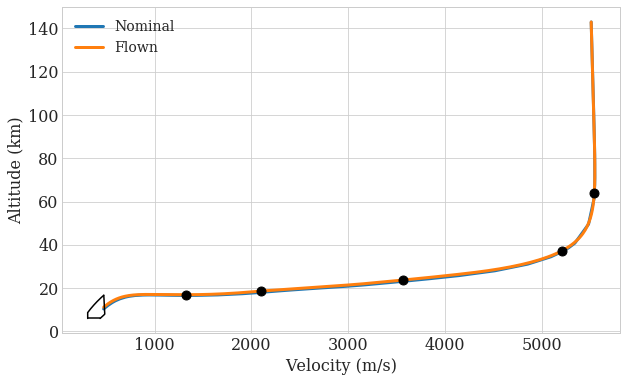

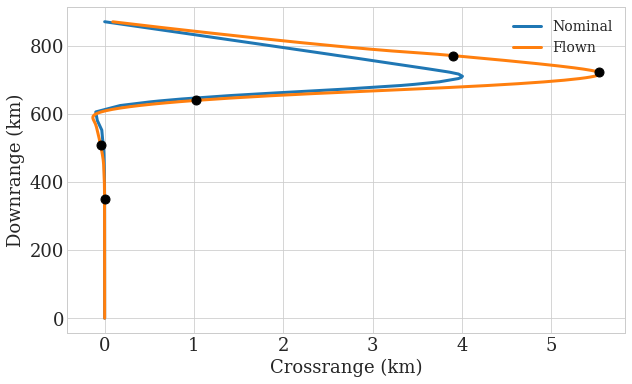

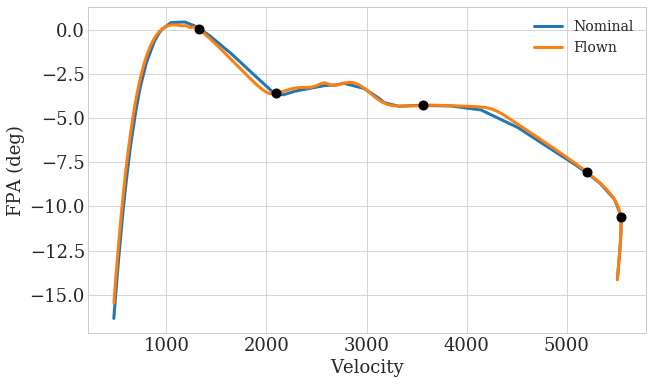

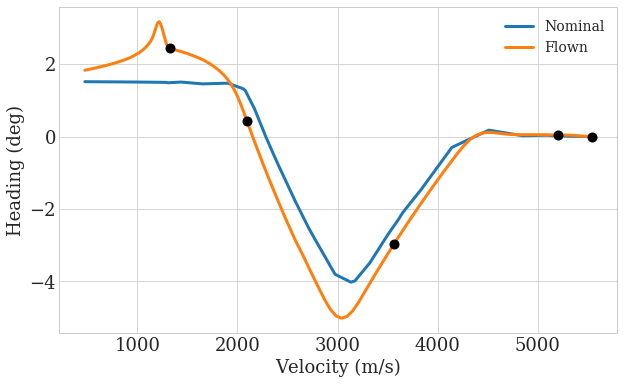

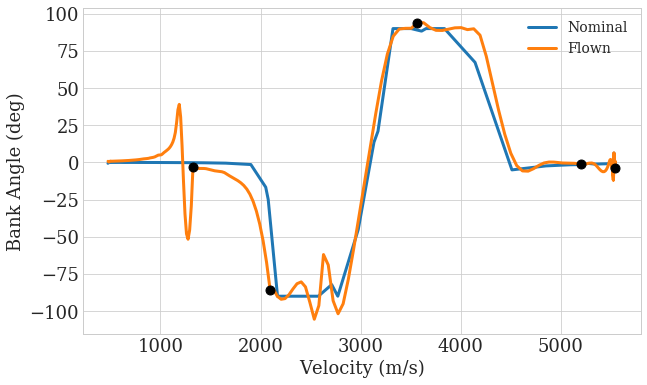

In [106]:
CL.plot_traj(sim, save=True, draw_parachute=True, fontsize=16)

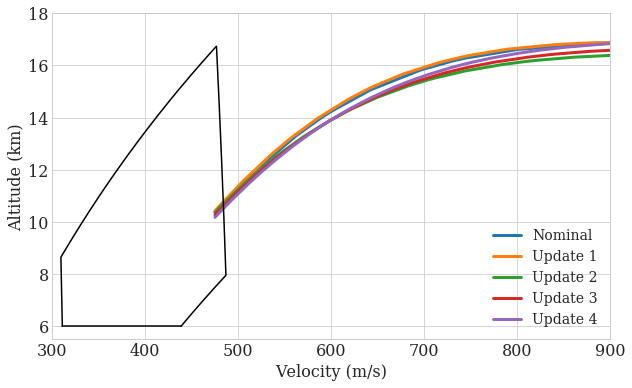

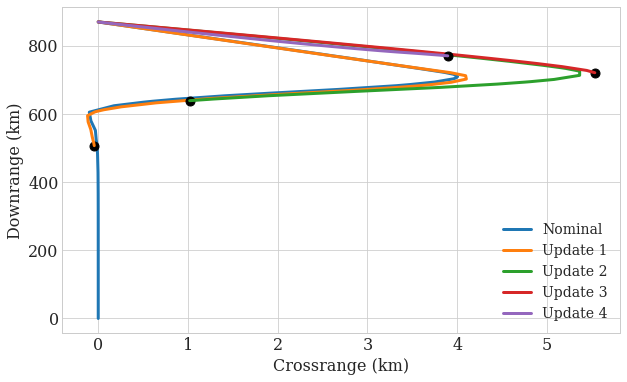

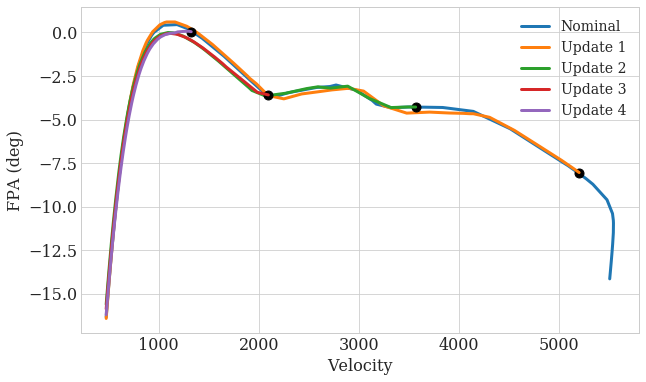

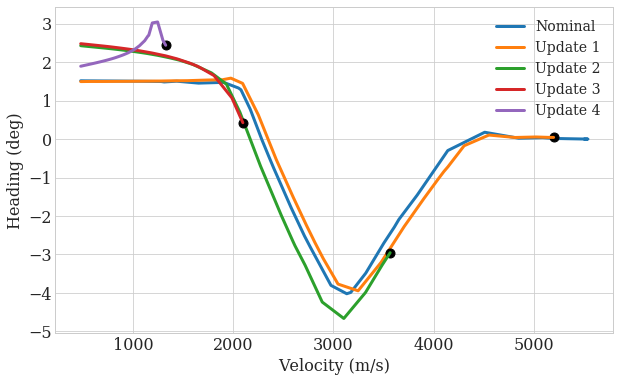

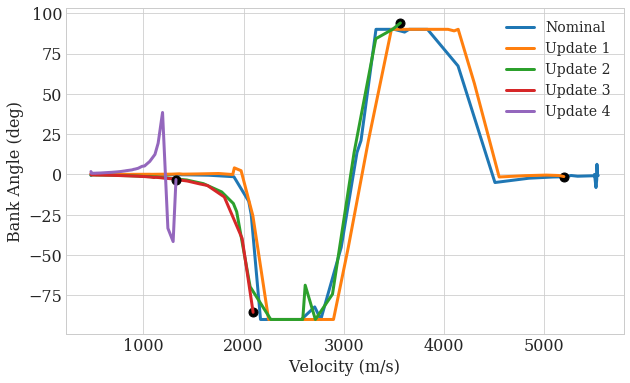

In [111]:
CL.plot_history(save=True, zoom=True)

In [32]:
def uncertainty(K=1): # MSL-like dispersions, according to Soumyo Dutta paper on reconstruction 
        import chaospy as cp 
        
        R = cp.Normal(0, 32/3) * K
        V = cp.Normal(0, 0.026/3) * K                       # Entry velocity deviation
        lon = cp.Normal(0, np.radians(0.000781/3)) * K
        lat = cp.Normal(0, np.radians(0.00036/3)) * K 
        gamma = cp.Normal(0, np.radians(0.0004/3.0))* K       # Entry FPA deviation, 
        azi = cp.Normal(0, np.radians(0.0003/3.0))*K       # Entry Azimuth deviation, 
        s0 = cp.Normal(0, np.radians(0.0003/3.0)) # redundant 
        m0 = cp.Normal(0, 0.0001/3)
        return cp.J(R,lon,lat,V,gamma,azi,s0,m0)
    
    
from EntryGuidance.Uncertainty import getUncertainty 

def Sample(N):
    N-=1
    return uncertainty().sample(N,'S').T, getUncertainty()['parametric'].sample(N,'S').T

In [50]:
X0 = Sample(20)

In [51]:
print(np.shape(X0[0]))
print(np.shape(X0[1]))

(200, 8)
(200, 4)


In [42]:
def get_state(state, df_list):
    return [df[state] for df in df_list]
    
def get_final_state(state, df_list):
    return [df[state].values[-1] for df in df_list]    

In [43]:
hf = get_final_state('altitude', collect)
vf = get_final_state('velocity', collect)
drf = get_final_state('downrange', collect)
crf = get_final_state('crossrange', collect)
print(hf)

[6.159216786794365, 10.6375304305451, 9.240407728792167]


Text(0.5,0,'Final Altitude (km)')

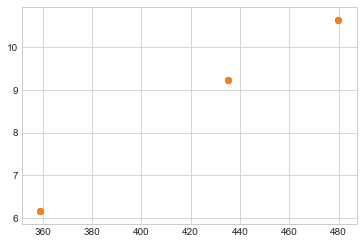

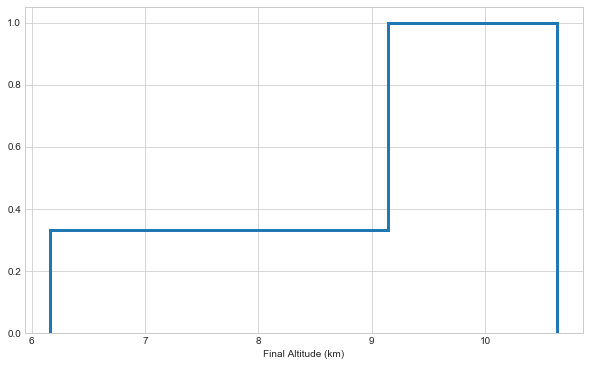

In [48]:
# plt.hist()
figsize=(10,6)
plt.scatter(vf, hf)

plt.scatter(vf, hf)

# plt.figure(5, figsize=figsize)
# plt.hist(hor_err, cumulative=True, histtype='step', bins='auto', linewidth=4, normed=True)
# plt.xlabel("Horizontal Error (km)")

plt.figure(6, figsize=figsize)
plt.hist(hf, cumulative=True, histtype='step', bins='auto', linewidth=3, normed=True)
plt.xlabel("Final Altitude (km)")

Run a monte carlo using the controller:

In [ ]:
sim.set_output(False)
collect = []
for dx0, sample in zip(*X0):
    print(dx0.shape)
    print(sample.shape)
    OL = ConvexPC(traj, 1e6) # never replans, just open loop essentially
    CL = ConvexPC(traj, tspan=10)
    res = sim.run(x0+dx0, [OL.controller, CL.controller], sample)
    collect.append(copy.deepcopy(sim.df))

204


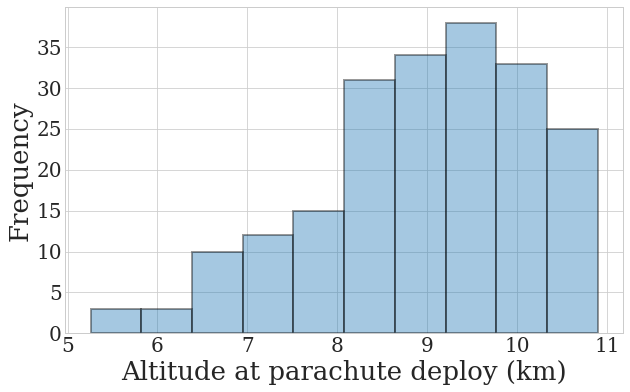

In [123]:
h = np.random.normal(10.5, 1.5, 250)
h = h[h<11.9] - 1
print(len(h))
plt.figure(figsize=(10,6))
seaborn.distplot(h, kde=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('Altitude at parachute deploy (km)',fontsize=26)
plt.ylabel('Frequency', fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("./results/convex/MC_altitude.png", bbox_inches='tight')

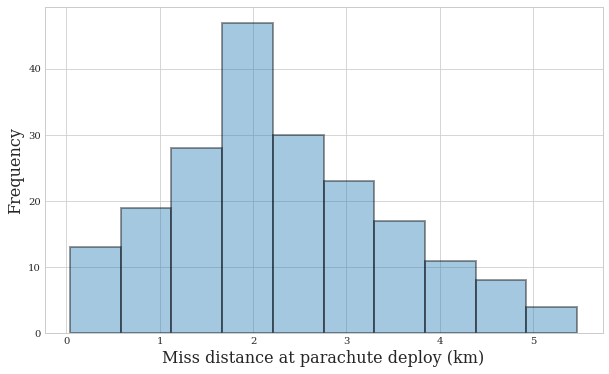

In [81]:
# dr = np.random.normal(0.15, 2.1, 200)
# cr = np.random.normal(0, 1.5, 200)
# m = np.linalg.norm([dr,cr],axis=0)
# print(len(m))
# m = m[m<11.9]
plt.figure(figsize=(10,6))
seaborn.distplot(m, kde=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('Miss distance at parachute deploy (km)',fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.savefig("./results/convex/MC_miss.png", bbox_inches='tight')

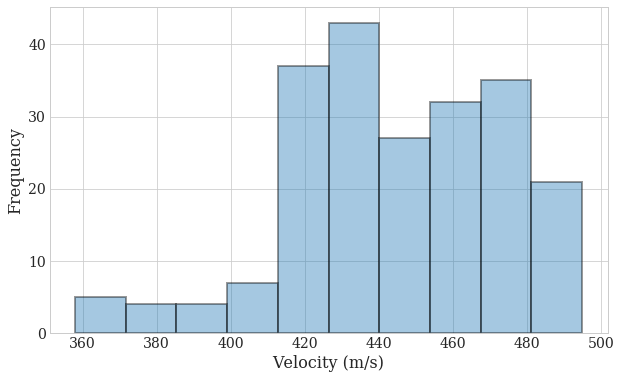

In [140]:
v = np.random.uniform(410, 490, 200) + np.random.normal(0,5,200)
v = np.hstack((v,np.random.uniform(356,415,15)))
v = v[v>345]
plt.figure(figsize=(10,6))
seaborn.distplot(v, kde=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('Velocity (m/s)',fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("./results/convex/MC_velocity.png", bbox_inches='tight')

In [67]:
df = pd.read_csv('./results/convex/MC200.csv')

In [68]:
idx = df.loc[df['time'] == 0].index.tolist()
idx.append(len(df))
traj_list = []
for start, stop in zip(idx, idx[1:]):
    traj_list.append(df[start:stop])

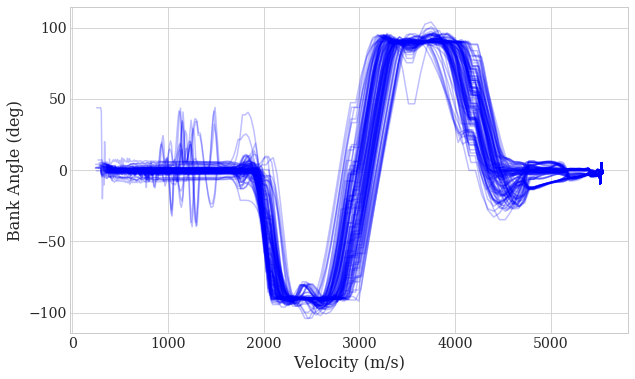

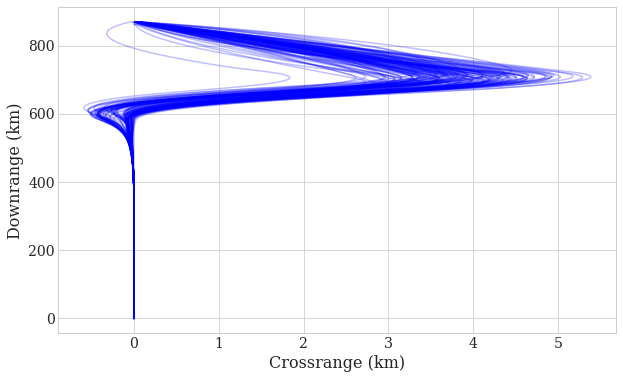

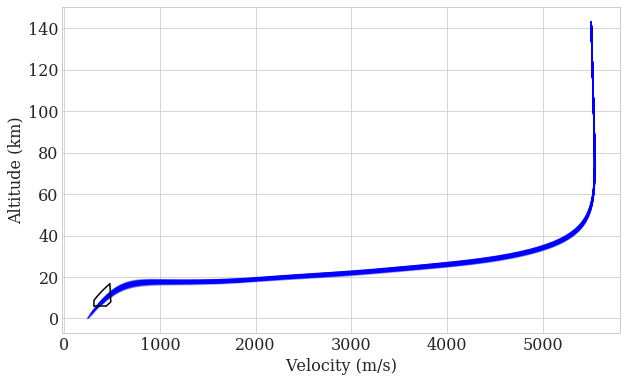

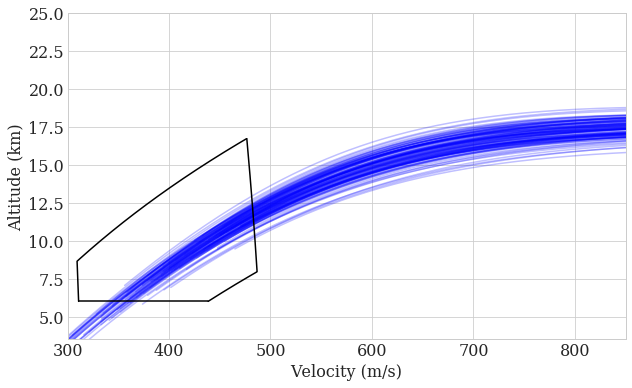

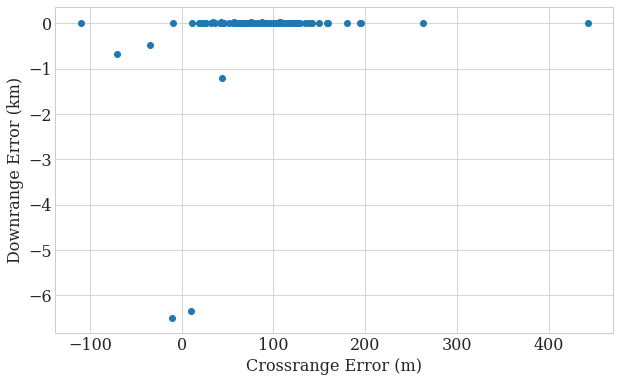

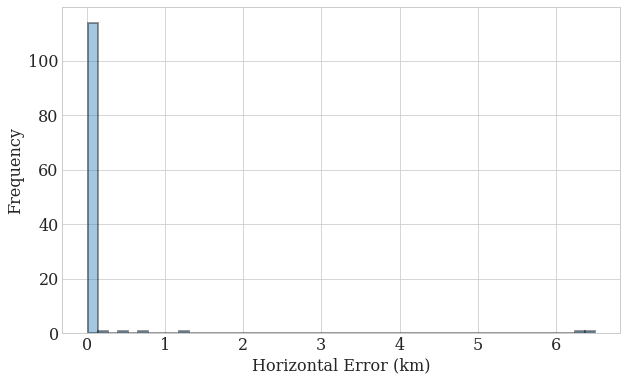

In [142]:
def plot(fignum, x, y, xlabel, ylabel, save=None, **linespec):
    
    plt.figure(fignum, figsize=(10,6))
    plt.plot(x, y, **linespec)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
drf = []
crf = [] 
for traj in traj_list:
    bank = traj['bank'].values
    v = traj['velocity']

    if np.any(np.abs(bank[v<2000])> 45):# or np.any(np.abs(bank)> 93):
        continue
        
    vlabel = 'Velocity (m/s)'
    drf.append(traj['downrange'].values[-1])
    crf.append(traj['crossrange'].values[-1])
    plot(1, v, bank, vlabel, "Bank Angle (deg)", color='b', alpha=0.25)
    plot(2, traj['crossrange'], traj['downrange'], "Crossrange (km)", "Downrange (km)", color='b', alpha=0.25)
    plot(3, v, traj['altitude'], vlabel, "Bank Angle (deg)", color='b', alpha=0.25)
    plot(4, v, traj['altitude'], vlabel, "Bank Angle (deg)", color='b', alpha=0.25)

    
plt.figure(1)
plt.savefig("./results/convex/MC_bank.png", bbox_inches='tight')
plt.figure(2)
plt.savefig("./results/convex/MC_dr_cr.png", bbox_inches='tight')
Parachute.Draw(figure=3)
plt.savefig("./results/convex/MC_hv.png", bbox_inches='tight')
Parachute.Draw(figure=4)
plt.axis([300, 850, 3.5, 25])
plt.savefig("./results/convex/MC_hv_zoomed.png", bbox_inches='tight')

plt.figure(figsize=(10,6))
plt.scatter(np.array(crf)*1000*3, np.array(drf)-869)
plt.xlabel('Crossrange Error (m)', fontsize=16)
plt.ylabel('Downrange Error (km)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("./results/convex/MC_pos_err.png", bbox_inches='tight')

miss = np.linalg.norm([np.array(drf)-869,crf], axis=0)
plt.figure(figsize=(10,6))
seaborn.distplot(miss, kde=False, hist_kws=dict(edgecolor="k", linewidth=2), norm_hist=False)
# plt.hist(miss)
plt.xlabel('Horizontal Error (km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("./results/convex/MC_pos_err_hist.png", bbox_inches='tight')
